In [53]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import backtrader as bt
from typing import Tuple, List
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

Load & align data

In [54]:
price_path   = r'C:\Users\Leo Hubmann\Desktop\thesis\data\price_data\bitcoin_2021_2024.csv'
vader_path   = r'C:\Users\Leo Hubmann\Desktop\BachelorThesis_data\all_daily_vader_sentiment_v2.csv'
finbert_path = r'C:\Users\Leo Hubmann\Desktop\BachelorThesis_data\all_daily_finbert_sentiment_v4.csv'

In [55]:
price = (pd.read_csv(price_path,   parse_dates=['date'], low_memory=False)
         .set_index('date')
         .loc['2020-12-31':'2024-12-31', 'close'])

In [56]:
vader = (pd.read_csv(vader_path,   parse_dates=['date'], low_memory=False)
        .set_index('date')['daily_vader_sentiment'])

In [57]:
finbert = (pd.read_csv(finbert_path, parse_dates=['date'], low_memory=False)
        .set_index('date')['daily_finbert_score'])

In [58]:
df = pd.concat({'close': price, 'vader': vader, 'finbert': finbert}, axis=1)

In [59]:
# compute log returns
df['ret'] = np.log(df['close']).diff()
df = df.dropna()

Build the signal

- Uses only past 90 days for the mean/std → no data leakage.
- Equal-weight average after standardisation gives each model equal influence.
- Outliers capped to ±3σ so a single Reddit outlier won’t compromise the allocation.

“To combine VADER and FinBERT scores, each series is transformed into a 90-day rolling z-score to eliminate scale and mean differences. The two normalised series are then averaged to form a composite sentiment index. Extreme values beyond ±3 σ are capped to reduce the impact of rare Reddit-driven sentiment spikes”

In [60]:
ROLL_Z = 90     # rolling z-score window

# rolling standardisation (finbert and vader do not have the same scale)
roll_mean_v = vader.rolling(ROLL_Z).mean()
roll_std_v  = vader.rolling(ROLL_Z).std()

roll_mean_f = finbert.rolling(ROLL_Z).mean()
roll_std_f  = finbert.rolling(ROLL_Z).std()

df['vader_z']   = (df['vader']   - roll_mean_v) / roll_std_v
df['finbert_z'] = (df['finbert'] - roll_mean_f) / roll_std_f

In [61]:
# composite sentiment
df['sent_raw'] = df[['vader_z', 'finbert_z']].mean(axis=1)

# optional: cap extreme z-scores to +/- 3 to tame outliers
# df['sent_raw'] = df['sent_raw'].clip(lower=-3, upper=3)

In [62]:
df[['vader_z', 'finbert_z', 'sent_raw']].describe()

,vader_z,finbert_z,sent_raw
count,1372.000000,1372.000000,1372.000000
mean,-0.021347,-0.022083,-0.021715
std,1.061312,1.054883,0.947772
min,-4.720014,-3.094124,-3.782256
25%,-0.679890,-0.804048,-0.655746
50%,0.028530,-0.037667,-0.005755
75%,0.689570,0.672782,0.622120
max,7.239749,5.019495,6.129622


In [63]:
display(df.head(120))

,close,vader,finbert,ret,vader_z,finbert_z,sent_raw
date,,,,,,,
2021-01-01,29374.1523,0.230888,-0.085924,0.012760,NaN,NaN,NaN
2021-01-02,32127.2676,0.211708,-0.095451,0.089590,NaN,NaN,NaN
2021-01-03,32782.0234,0.235294,-0.089225,0.020175,NaN,NaN,NaN
2021-01-04,31971.9141,0.218767,-0.122876,-0.025022,NaN,NaN,NaN
2021-01-05,33992.4297,0.230068,-0.102810,0.061280,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-04-26,54021.7539,0.223365,-0.124373,0.097480,0.424692,0.158709,0.291701
2021-04-27,55033.1172,0.241574,-0.010555,0.018548,1.288615,2.106506,1.697561
2021-04-28,54824.7031,0.247576,-0.050380,-0.003794,1.547594,1.378349,1.462971


We roll 60 days to obtain 75th/25th percentiles (no look-ahead bias)
and test EMA spans 3–10 on 2021-23 (in-sample).  The best span is then
frozen for 2024 (out-of-sample).

In [64]:
# params
TRAIN_END   = '2023-12-31'     # IS / OOS split
ROLL_PCT    = 60               # window for percentile thresholds
TH_UP, TH_DN = 0.75, 0.25      # 75th / 25th percentiles
TC          = 0.001            # 0.10 % round-trip cost
EMA_GRID    = range(3, 11)     # spans to test (3…10)


In [65]:
# functions for the necessary metrics

SHARPE_DAYS = 365          # 365 for crypto

# annual sharpe, but with rf = 0
def ann_sharpe(ret: pd.Series) -> float:
    return np.sqrt(SHARPE_DAYS) * ret.mean() / ret.std()

def cum_curve(ret: pd.Series) -> pd.Series:
    """Cumulative growth of 1 unit."""
    return np.exp(ret.cumsum())

def max_drawdown(ret: pd.Series) -> float:
    r   = ret.fillna(0)            # ← ①  replace first NaN by 0-return
    eq  = np.exp(r.cumsum())       # cumulative equity
    roll_max = np.maximum.accumulate(eq)
    dd  = 1 - eq / roll_max
    return dd.max()


In [14]:
# # strategy function
# def build_strategy(df_in: pd.DataFrame, ema_span: int, return_alloc=False):
#    
#     d = df_in.copy()
# 
#     # 1) Smooth sentiment
#     d['sent_ema'] = d['sent_raw'].ewm(span=ema_span, adjust=False).mean()
# 
#     # 2) Adaptive thresholds
#     p75 = d['sent_ema'].rolling(ROLL_PCT).quantile(TH_UP)
#     p25 = d['sent_ema'].rolling(ROLL_PCT).quantile(TH_DN)
# 
#     # 3) Regime classification → allocation
#     d['regime'] = np.where(d['sent_ema'] > p75, 'bull',
#                            np.where(d['sent_ema'] < p25, 'bear', 'neutral'))
#     alloc_map = {'bull': 1.0, 'neutral': 0.1, 'bear': 0.0}
#     d['alloc_daily'] = d['regime'].map(alloc_map)
# 
#     # 4) Weekly rebalance (Monday close)
#     d['alloc'] = (d['alloc_daily']
#                   .resample('W-MON')
#                   .first()
#                   .reindex(d.index, method='ffill'))
# 
#     # 5) Strategy returns with TC
#     alloc_prev = d['alloc'].shift()
#     tc = np.abs(d['alloc'] - alloc_prev) * TC
#     strat_ret = alloc_prev * d['ret'] - tc.fillna(0)
# 
#     if return_alloc:
#         return strat_ret, d['alloc']
#     return strat_ret

In [66]:
def build_strategy(df_in: pd.DataFrame, ema_span: int, th_up=TH_UP, th_dn=TH_DN, tc_param=TC, return_alloc=False):
    """
    Builds the sentiment strategy.
    Now includes optional threshold and transaction cost parameters.
    """
    d = df_in.copy()

    # 1) Smooth sentiment
    d['sent_ema'] = d['sent_raw'].ewm(span=ema_span, adjust=False).mean()

    # 2) Adaptive thresholds
    p75 = d['sent_ema'].rolling(ROLL_PCT).quantile(th_up)
    p25 = d['sent_ema'].rolling(ROLL_PCT).quantile(th_dn)

    # 3) Regime classification → allocation
    d['regime'] = np.where(d['sent_ema'] > p75, 'bull',
                           np.where(d['sent_ema'] < p25, 'bear', 'neutral'))
    alloc_map = {'bull': 1.0, 'neutral': 0.1, 'bear': 0.0}
    d['alloc_daily'] = d['regime'].map(alloc_map)

    # 4) Weekly rebalance (Monday close)
    d['alloc'] = (d['alloc_daily']
                  .resample('W-MON')
                  .first()
                  .reindex(d.index, method='ffill'))

    # 5) Strategy returns with TC
    alloc_prev = d['alloc'].shift(1)
    tc = np.abs(d['alloc'] - alloc_prev) * tc_param # Use tc_param argument
    strat_ret = alloc_prev * d['ret'] - tc.fillna(0)

    if return_alloc:
        return strat_ret, d['alloc']
    return strat_ret

In [67]:
# hyper param optimization (refer to BI lecture?) GRID-SEARCH  (find EMA span on 2021-23 data to avoid look-ahead)
is_mask = df.index <= TRAIN_END
grid_results: List[Tuple[int, float]] = []

for span in EMA_GRID:
    r   = build_strategy(df, span)
    sh  = ann_sharpe(r[is_mask])
    grid_results.append((span, sh))

best_span, best_sh    = max(grid_results, key=lambda x: x[1])
print(f'Best EMA span (IS 2021-23) = {best_span}   |  Sharpe = {best_sh:.2f}')

Best EMA span (IS 2021-23) = 5   |  Sharpe = 0.22



=== Quick performance check ===
IS  Sharpe: 0.22
OOS Sharpe: 2.7


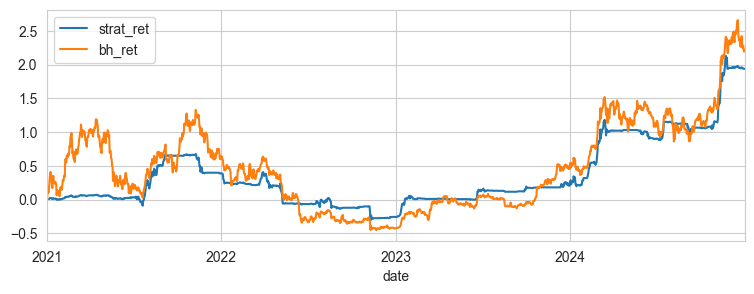

In [68]:
# strategy exec
df['strat_ret'] = build_strategy(df, best_span)
df['bh_ret']    = df['ret']                     # buy-and-hold benchmark

oos_mask        = df.index > TRAIN_END

print('\n=== Quick performance check ===')
print('IS  Sharpe:', ann_sharpe(df['strat_ret'][is_mask]).round(2))
print('OOS Sharpe:', ann_sharpe(df['strat_ret'][oos_mask]).round(2))

# cum performance (lol)
(np.exp(df[['strat_ret','bh_ret']].cumsum()) - 1).plot(figsize=(9,3));


Full                IS               OOS         
          Strategy Buy&Hold Strategy Buy&Hold Strategy Buy&Hold
Total Ret     1.94     2.22     0.21     0.46     1.43     1.21
Ann Vol       0.30     0.62     0.28     0.65     0.33     0.53
Sharpe        0.91     0.47     0.22     0.19     2.70     1.49
Max DD        0.59     0.77     0.59     0.77     0.14     0.26

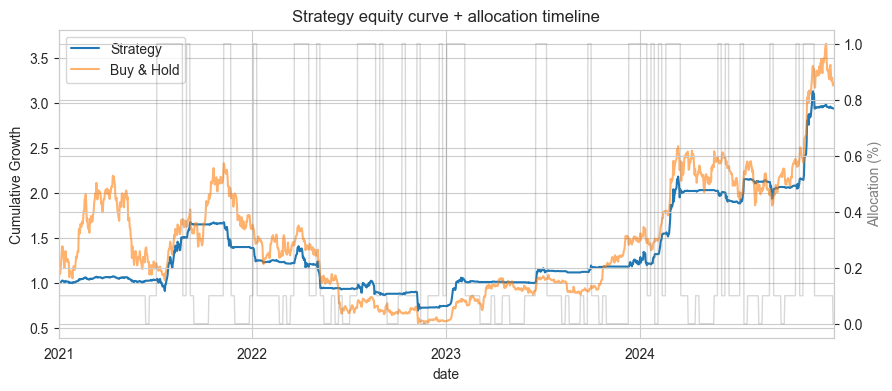

In [69]:
# single code block, directly with frozen ema

df['strat_ret'], df['alloc'] = build_strategy(df, best_span, return_alloc=True)
df['bh_ret'] = df['ret']

# performance table
def stats(label, r):
    return pd.Series({
        'Total Ret': cum_curve(r).iloc[-1] - 1,
        'Ann Vol': r.std()*np.sqrt(SHARPE_DAYS),
        'Sharpe': ann_sharpe(r),
        'Max DD': max_drawdown(r)
    }, name=label)

is_mask  = df.index <= TRAIN_END
oos_mask = df.index >  TRAIN_END

table = pd.concat({
    'Full':  pd.concat([stats('Strategy', df['strat_ret']),
                        stats('Buy&Hold', df['bh_ret'])], axis=1),
    'IS':    pd.concat([stats('Strategy', df.loc[is_mask, 'strat_ret']),
                        stats('Buy&Hold', df.loc[is_mask, 'bh_ret'])], axis=1),
    'OOS':   pd.concat([stats('Strategy', df.loc[oos_mask, 'strat_ret']),
                        stats('Buy&Hold', df.loc[oos_mask, 'bh_ret'])], axis=1)
}, axis=1).round(2)

display(table)

# equity + alloc overlay
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(10,4))
cum_curve(df['strat_ret']).plot(ax=ax1, label='Strategy')
cum_curve(df['bh_ret']).plot(ax=ax1, label='Buy & Hold', alpha=.6)
ax1.set_ylabel('Cumulative Growth')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
df['alloc'].plot(ax=ax2, color='grey', alpha=.3, linewidth=1)
ax2.set_ylabel('Allocation (%)', color='grey')
ax2.set_ylim(-0.05,1.05)
plt.title('Strategy equity curve + allocation timeline')
plt.show()

In [49]:
# ────────────────────────────────────────────────────────────────────────────
# 1.  Correlation diagnostics
# ────────────────────────────────────────────────────────────────────────────
corr_full = df[['strat_ret', 'ret']].dropna().corr().iloc[0,1]
corr_is   = df.loc[df.index<=TRAIN_END, ['strat_ret','ret']].dropna().corr().iloc[0,1]
corr_oos  = df.loc[df.index>TRAIN_END,  ['strat_ret','ret']].dropna().corr().iloc[0,1]

print("Correlation (daily log-returns)")
print(f"  Full sample : {corr_full:.2f}")
print(f"  In-sample   : {corr_is:.2f}")
print(f"  Out-of-sample: {corr_oos:.2f}")



Correlation (daily log-returns)
  Full sample : 0.58
  In-sample   : 0.55
  Out-of-sample: 0.68


In [50]:
neutrals = [0.1, 0.2, 0.3, 0.4]
rows = []

def build_strategy_neutral(df_in, ema_span, neutral_w):
    """Strategy A variant with configurable neutral allocation."""
    d = df_in.copy()
    d['sent_ema'] = d['sent_raw'].ewm(span=ema_span, adjust=False).mean()
    p75 = d['sent_ema'].rolling(ROLL_PCT).quantile(TH_UP)
    p25 = d['sent_ema'].rolling(ROLL_PCT).quantile(TH_DN)
    d['regime'] = np.where(d['sent_ema']>p75,'bull',
                    np.where(d['sent_ema']<p25,'bear','neutral'))
    alloc_map = {'bull':1.0, 'neutral':neutral_w, 'bear':0.0}
    d['alloc_daily'] = d['regime'].map(alloc_map)
    d['alloc'] = (d['alloc_daily']
                  .resample('W-MON').first()
                  .reindex(d.index, method='ffill'))
    alloc_prev = d['alloc'].shift()
    fee = np.abs(d['alloc']-alloc_prev)*TC
    return alloc_prev * d['ret'] - fee.fillna(0)

for n in neutrals:
    best_span, best_sh = None, -9e9
    for span in EMA_GRID:
        r = build_strategy_neutral(df, span, n)      # use helper from last cell
        sh_is = ann_sharpe(r.loc[:TRAIN_END])
        if sh_is > best_sh:
            best_span, best_sh = span, sh_is
    rows.append((n, best_span, round(best_sh,2), round(ann_sharpe(r.loc[TRAIN_END:]),2)))
pd.DataFrame(rows, columns=['Neutral','Best_EMA','IS_Sharpe','OOS_Sharpe'])


# output neatly
sweep = pd.DataFrame(rows, columns=['Neutral_w','Best_EMA','IS_Sharpe','OOS_Sharpe'])
display(sweep.round(2))

,Neutral_w,Best_EMA,IS_Sharpe,OOS_Sharpe
0,0.1,5,0.22,2.33
1,0.2,5,0.20,2.29
2,0.3,5,0.18,2.23
3,0.4,8,0.17,2.16


In [20]:
# save returns as csv
df[['strat_ret','alloc']].to_csv(r'C:\Users\Leo Hubmann\Desktop\thesis\data\strategyA_returns_alloc.csv')


In [51]:
def build_strategy_delayed(df_in, ema_span, tc_param=TC):
    """Strategy with a 1-day execution delay."""
    d = df_in.copy()
    
    # Steps 1-3: Generate the signal as usual
    d['sent_ema'] = d['sent_raw'].ewm(span=ema_span, adjust=False).mean()
    p75 = d['sent_ema'].rolling(ROLL_PCT).quantile(TH_UP)
    p25 = d['sent_ema'].rolling(ROLL_PCT).quantile(TH_DN)
    d['regime'] = np.where(d['sent_ema'] > p75, 'bull',
                           np.where(d['sent_ema'] < p25, 'bear', 'neutral'))
    alloc_map = {'bull': 1.0, 'neutral': 0.1, 'bear': 0.0}
    d['alloc_daily'] = d['regime'].map(alloc_map)
    
    # Step 4: Resample to get weekly target allocation
    d['alloc_target'] = (d['alloc_daily']
                         .resample('W-MON').first()
                         .reindex(d.index, method='ffill'))
    
    # Step 5: Introduce the 1-day delay. The allocation we *actually* hold
    # is the target from the previous day.
    d['alloc_actual'] = d['alloc_target'].shift(1)
    
    # Step 6: Calculate returns based on the delayed (actual) allocation
    alloc_prev = d['alloc_actual'].shift(1)
    tc = np.abs(d['alloc_actual'] - alloc_prev) * tc_param
    strat_ret = alloc_prev * d['ret'] - tc.fillna(0)
    
    return strat_ret

In [70]:
print("\n--- Implementation Robustness Tests (OOS) ---")

# Define scenarios
scenarios = {
    'Baseline (0.10% TC)':   {'tc': 0.001, 'delay': False},
    'Low TC (0.05%)':        {'tc': 0.0005, 'delay': False},
    'High TC (0.20%)':       {'tc': 0.002, 'delay': False},
    '1-day execution delay': {'tc': 0.001, 'delay': True}
}

robustness_results = {}

for name, params in scenarios.items():
    if params['delay']:
        # Run the delayed strategy simulation
        returns = build_strategy_delayed(df, best_span, tc_param=params['tc'])
    else:
        # Run the standard strategy simulation with the specified TC
        returns = build_strategy(df, best_span, tc_param=params['tc'])
    
    # Calculate stats on the OOS portion of the returns
    robustness_results[name] = stats(name, returns[oos_mask])

# Create and display the final table
robustness_table = pd.DataFrame(robustness_results).T
display(robustness_table.round(2))


--- Implementation Robustness Tests (OOS) ---


,Total Ret,Ann Vol,Sharpe,Max DD
Baseline (0.10% TC),1.43,0.33,2.70,0.14
Low TC (0.05%),1.45,0.33,2.73,0.14
High TC (0.20%),1.39,0.33,2.65,0.14
1-day execution delay,1.37,0.34,2.53,0.18
